In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_percentage_error as mean_ape
from sklearn.metrics import root_mean_squared_error as root_mse

from sklearn.linear_model import LinearRegression

In [2]:
model_data_no_journal = pd.read_parquet("data/model_data_no_journal.parquet")
model_data_no_journal = model_data_no_journal[model_data_no_journal['political_alignment'] != 'autre']
model_data_no_journal['next_pres_votes_share'] = model_data_no_journal['pres_dummy'] * model_data_no_journal['pres_votes_share']

model_data = pd.read_parquet("data/model_data.parquet")
model_data = model_data[model_data['political_alignment'] != 'autre']
model_data['next_pres_votes_share'] = model_data['pres_dummy'] * model_data['pres_votes_share']

In [3]:
nuances_order = ["Far right", "Right", "Center", "Left", "Far left"]

variables_dict = {
    'government': 'Government Participation',
    'leg_votes_share': 'Vote Share in Last Legislative Election',
    'na_share': 'Share of MPs',
    'next_pres_votes_share': 'Vote Share in Next Presidential Election'}

In [4]:
outcome = "quotes_share"

## 1. Modèle de base = sièges à l'AN
De la forme $Y_{i} = \beta T_{i}$ avec :
- $Y_{i}$ la proportion des articles intégrant des citations de la nuance politique $i$ (avec $\sum_{i=1}^{n} Y_{i} = 1$)
- $\beta$ la pondération du nombre de sièges détenus les différentes nuances politiques représentées à l'Assemblée
- $T_{i}$ la proportion des sièges détenus par la nuance politique $i$

In [5]:
model_data_no_journal["last_election"] = model_data_no_journal["last_election"].dt.year.astype(str)
model_data["last_election"] = model_data["last_election"].dt.year.astype(str)

In [6]:
regressors = ["na_share"]
X = model_data_no_journal[regressors]
y = model_data_no_journal[outcome]
model = LinearRegression(positive=True, fit_intercept=False)
model.fit(X, y)
y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

print(pd.DataFrame({'feature': regressors, 'coefficient': model.coef_}))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

    feature  coefficient
0  na_share      0.90792

MAPE: 71.12%
RMSPE: 0.38013


## 2. Sièges à l'AN + participation au gouvernement
De la forme $Y_{i} = \beta T_{i} + \gamma G_{i}$ avec :
- $\gamma$ la proportion des articles intégrant des citations dont bénéficie la nuance politique du gouvernement
- $G_{i}$ une indicatrice valant 1 si le Premier ministre appartient à la nuance politique $i$

In [7]:
regressors = ["na_share", "government"]
X = model_data_no_journal[regressors]
y = model_data_no_journal[outcome]
model = LinearRegression(positive=True, fit_intercept=False)
model.fit(X, y)
y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

print(pd.DataFrame({'feature': regressors, 'coefficient': model.coef_}))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

      feature  coefficient
0    na_share     0.882946
1  government     0.019752

MAPE: 70.08%
RMSPE: 0.37940


## 3. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives
Les modèles estimés sont de la forme $Y_{i} = \beta T_{i} + \gamma G_{i} + \theta P_{i} + \delta L_{i}$ avec :
- $\theta$ la pondération des résultats aux élections présidentielles des différentes nuances politiques
- $P_{i}$ la proportion des voix obtenues par la nuance politique $i$ à l'élection présidentielle suivante (pour le mois de l'élection et les quatre précédents)
- $\delta$ la pondération des résultats aux élections législatives des différentes nuances politiques
- $L_{i}$ la proportion des voix obtenues par la nuance politique $i$ à l'élection législative précédente

In [8]:
regressors = ["na_share", "government", "leg_votes_share", "next_pres_votes_share"]
X = model_data_no_journal[regressors]
y = model_data_no_journal[outcome]
model = LinearRegression(positive=True, fit_intercept=False)
model.fit(X, y)
y_pred = model.predict(X)
mape = mean_ape(y, y_pred)
rmspe = root_mse(y, y_pred) / y.mean()

print(pd.DataFrame({
    'feature': regressors,
    'coefficient': model.coef_}))
print("")
print(f"MAPE: {100*mape:.2f}%")
print(f"RMSPE: {rmspe:.5f}")

                 feature  coefficient
0               na_share     0.476795
1             government     0.070054
2        leg_votes_share     0.724434
3  next_pres_votes_share     0.026288

MAPE: 62.22%
RMSPE: 0.31091


## 4. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives // nuances politiques
Les modèles estimés sont de la forme $Y_{i} = \beta_{i} T_{i} + \gamma_{i} G_{i} + \theta_{i} P_{i} + \delta_{i} L_{i}$ : les effets deviennent spécifiques à chaque nuance politique.

In [9]:
regressors = ["na_share", "government", "leg_votes_share", "next_pres_votes_share"]
models = {}

for alignment in model_data_no_journal["political_alignment"].unique():
    subset = model_data_no_journal[model_data_no_journal["political_alignment"] == alignment]

    if len(subset) >= 3:
        X = subset[regressors] 
        y = subset[outcome]
        model = LinearRegression(positive=True, fit_intercept=False)
        model.fit(X, y)
        y_pred = model.predict(X)
        mape = mean_ape(y, y_pred)
        rmspe = root_mse(y, y_pred) / y.mean()
        
        models[alignment] = {
            "params": pd.DataFrame({
                'feature': regressors,
                'coefficient': model.coef_}),
            "mape": mape,
            "rmspe": rmspe}

    else:
        models[alignment] = {
            "params": None,
            "mape": None,
            "rmspe": None}

In [10]:
summary = []

for alignment, model_info in models.items():
    summary.append({
        "alignment": alignment,
        "mape": model_info["mape"],
        "rmspe": model_info["rmspe"]
    })

results = pd.DataFrame(summary)
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.sort_values("alignment").reset_index(drop=True)

results.style.hide(axis="index") 

alignment,mape,rmspe
Far right,0.540136,0.600268
Right,0.153006,0.154430
Center,0.756459,0.561294
Left,0.227525,0.238993
Far left,0.504498,0.518721


In [11]:
results_list = []

for alignment, model_info in models.items():
    df = model_info["params"]
    df["alignment"] = alignment
    df["variable"] = df.index
    results_list.append(df.reset_index(drop=True))

results = pd.concat(results_list, ignore_index=True)
results.drop(columns='variable', inplace=True)
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.sort_values(["feature", "alignment"])
results = results.set_index(["feature", "alignment"])
results.index.names = ["", "Political Alignment"]
results.index = results.index.set_levels(
    results.index.levels[0].to_series().replace(variables_dict).values,
    level=0)

results.style.format("{:.4f}")

## 5. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives // nuances politiques + périodes
Il s'agit maintenant d'étudier plus directement l'hypothèse d'une légitimation de l'extrême droite par la presse écrite nationale. La méthode la plus simple est d'estimer les modèles précédents pour 2 périodes, afin d'observer l'évolution des coefficients. Les modèles estimés sont de la forme $Y_{it} = \beta_{it} T_{it} + \gamma_{it} G_{it} + \theta_{it} P_{it} + \delta_{it} L_{it}$ : les effets deviennent spécifiques à chaque période $t$.

On retient 2017 comme charnière, avec l'idée que...
- La période précédente est encore marquée par le jeu fonctionnement traditionnel du système politique, avec une domination persistante de la droite et de la gauche de gouvernement, malgré leurs recompositions.
- La période suivante est caractérisée par l'effondrement de ce système, avec l'essort du centre et des extrêmes.

In [23]:
regressors = ["na_share", "government", "leg_votes_share", "next_pres_votes_share"]
cutoff1 = pd.Period('2002-06', freq='M')
cutoff2 = pd.Period('2017-06', freq='M')

models = {}

for period_label, period_filter in {
    '1981-2002': model_data_no_journal["month"] < cutoff1,
    '2002-2017': (model_data_no_journal["month"] >= cutoff1) & (model_data_no_journal["month"] < cutoff2),
    '2017-2024': model_data_no_journal["month"] >= cutoff2
}.items():
    
    models[period_label] = {}
    period_data = model_data_no_journal[period_filter]
    
    for alignment in period_data["political_alignment"].unique():
        models[period_label][alignment] = {}
        subset = period_data[period_data["political_alignment"] == alignment]

        if len(subset) >= 3:
            X = subset[regressors] 
            y = subset[outcome]
            model = LinearRegression(positive=True, fit_intercept=False)
            model.fit(X, y)
            y_pred = model.predict(X)
            mape = mean_ape(y, y_pred)
            rmspe = root_mse(y, y_pred) / y.mean()

            models[period_label][alignment] = {
                "params": pd.DataFrame({
                    'feature': regressors,
                    'coefficient': model.coef_}),
                "mape": mape,
                "rmspe": rmspe}

        else:
            models[period_label][alignment] = {
                "params": None,
                "mape": None,
                "rmspe": None}

In [24]:
summary_list = []

for period, alignment_dict in models.items():
    for alignment, model_info in alignment_dict.items():
        summary_list.append({
            "period": period,
            "alignment": alignment,
            "mape": model_info["mape"],
            "rmspe": model_info["rmspe"]
        })

summary = pd.DataFrame(summary_list)
summary["alignment"] = pd.Categorical(summary["alignment"], categories=nuances_order, ordered=True)
summary = summary.pivot_table(index="alignment",
                                      columns="period",
                                      values=["mape", "rmspe"],
                                      observed=False)
summary = summary.reset_index()
summary.columns.names = [None, None]

format_cols = summary.columns[1:]
summary.style.hide(axis="index").format({col: "{:.3f}" for col in format_cols})

In [25]:
results_list = []

for period, alignment_dict in models.items():
    for alignment, model_info in alignment_dict.items():
        df = model_info["params"]
        df["period"] = period
        df["alignment"] = alignment
        results_list.append(df.reset_index(drop=True))

results = pd.concat(results_list, ignore_index=True)
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.pivot_table(index=["feature", "alignment"],
                              columns="period",
                              values=["feature"],
                              observed=False)
results.columns = results.columns.swaplevel(0, 1)
results = results.reindex(columns=["1981-2002", "2002-2017", "2017-2024"], level=0)
results = results.sort_index()
results.index.names = ["", "Political Alignment"]
results.columns.names = [None, None]
results.index = results.index.set_levels(
    results.index.levels[0].to_series().replace(variables_dict).values,
    level=0)

results.style.format({col: "{:.4f}" for col in results.columns})

## 6. Sièges à l'AN + participation au gouvernement + score aux présidentielles et aux législatives // nuances politiques + périodes + journaux
On différencie finalement selon les journaux. Les modèles estimés sont de la forme $Y_{ijt} = \beta_{ijt} T_{ijt} + \gamma_{ijt} G_{ijt} + \theta_{ijt} P_{ijt} + \delta_{ijt} L_{ijt}$ : les effets deviennent spécifiques à chaque journal $j$.

In [15]:
regressors = ["na_share", "government", "leg_votes_share", "next_pres_votes_share"]
cutoff = pd.Period('2017-06', freq='M')

models = {}

for period_label, period_filter in {
    'pre2017': model_data["month"] < cutoff,
    'post2017': model_data["month"] >= cutoff
}.items():
    
    models[period_label] = {}
    period_data = model_data[period_filter]
    
    for alignment in period_data["political_alignment"].unique():
        models[period_label][alignment] = {}
        subset = period_data[period_data["political_alignment"] == alignment]
        
        for journal in period_data["journal"].unique():
            sub_subset = subset[subset["journal"] == journal]

            if len(subset) >= 3:
                X = sub_subset[regressors] 
                y = sub_subset[outcome]
                model = LinearRegression(positive=True, fit_intercept=False)
                model.fit(X, y)
                y_pred = model.predict(X)
                mape = mean_ape(y, y_pred)
                rmspe = root_mse(y, y_pred) / y.mean()

                models[period_label][alignment][journal] = {
                    "params": pd.DataFrame({
                        'feature': regressors,
                        'coefficient': model.coef_}),
                    "mape": mape,
                    "rmspe": rmspe}

            else:
                models[period_label][alignment][journal] = {
                    "params": None,
                    "mape": None,
                    "rmspe": None}

In [16]:
summary = []

for period, alignment_dict in models.items():
    for alignment, journal_dict in alignment_dict.items():
        for journal, model_info in journal_dict.items():
            summary.append({
                "period": period,
                "alignment": alignment,
                "journal": journal,
                "mape": model_info["mape"],
                "rmspe": model_info["rmspe"]
            })

results = pd.DataFrame(summary)
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.pivot_table(index=["alignment", "journal"],
                              columns="period",
                              values=["mape", "rmspe"],
                              observed=False)
results.index.names = ["Political alignment", "Journal"]
results.columns.names = [None, None]

format_cols = results.columns
results.style.format({col: "{:.3f}" for col in format_cols})

In [17]:
results_list = []

for period, alignment_dict in models.items():
    for alignment, journal_dict in alignment_dict.items():
        for journal, model_info in journal_dict.items():
            df = model_info["params"]
            df["period"] = period
            df["alignment"] = alignment
            df["journal"] = journal
            results_list.append(df.reset_index(drop=True))

results = pd.concat(results_list, ignore_index=True)
results["alignment"] = pd.Categorical(results["alignment"], categories=nuances_order, ordered=True)
results = results.pivot_table(index=["feature", "alignment", "journal"],
                              columns="period",
                              values=["feature"],
                              observed=False)

results.columns = results.columns.swaplevel(0, 1)
results = results.reindex(columns=["pre2017", "post2017"], level=0)
results = results.sort_index()
results.index.names = ["", "Political alignment", "Journal"]
results.index = results.index.set_levels(
    results.index.levels[0].to_series().replace(variables_dict).values,
    level=0)

results.style.format({col: "{:.4f}" for col in results.columns})

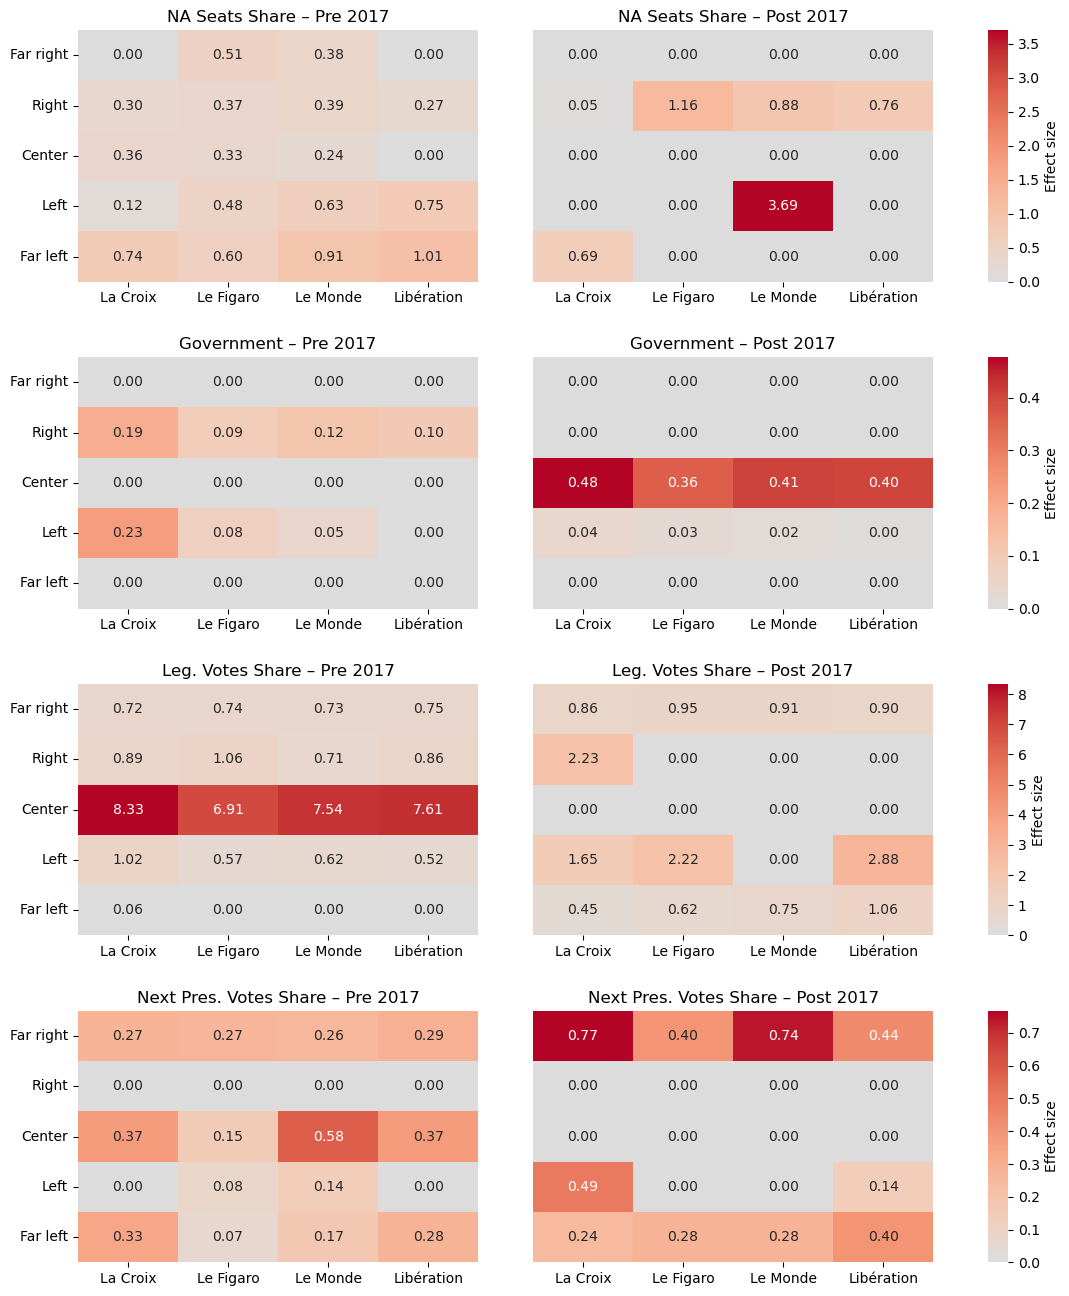

In [18]:
combinations = [
    ('na_share', 'pre2017'),
    ('na_share', 'post2017'),
    ('government', 'pre2017'),
    ('government', 'post2017'),
    ('leg_votes_share', 'pre2017'),
    ('leg_votes_share', 'post2017'),
    ('next_pres_votes_share', 'pre2017'),
    ('next_pres_votes_share', 'post2017'),]

titles = [
    'NA Seats Share – Pre 2017',
    'NA Seats Share – Post 2017',
    'Government – Pre 2017',
    'Government – Post 2017',
    'Leg. Votes Share – Pre 2017',
    'Leg. Votes Share – Post 2017',
    'Next Pres. Votes Share – Pre 2017',
    'Next Pres. Votes Share – Post 2017',]

heatmap_data = []
row_counts = []

for var, period in combinations:
    var_label = variables_dict[var]
    idx = results.index
    mask = ((idx.get_level_values(0) == var_label) &
            (idx.get_level_values('Journal') != 'Médiapart'))
    sub = results[mask][(period, 'coefficient')]
    sub.index = sub.index.droplevel(0)
    pivot = sub.unstack(level=1)
    heatmap_data.append(pivot)
    row_counts.append(pivot.shape[0])

row_limits = []
for r in range(4):
    d1 = heatmap_data[2*r]
    d2 = heatmap_data[2*r+1]
    combined = pd.concat([d1, d2]).values.flatten()
    if combined.size == 0:
        vmin, vmax = 0, 0
    else:
        vmin, vmax = np.nanmin(combined), np.nanmax(combined)
    row_limits.append((vmin, vmax))

fig = plt.figure(figsize=(12, 16))
gs = gridspec.GridSpec(
    4, 3,
    width_ratios=[1, 1, 0.05],
    height_ratios=[
        max(row_counts[0:2])/max(row_counts),
        max(row_counts[2:4])/max(row_counts),
        max(row_counts[4:6])/max(row_counts),
        max(row_counts[6:8])/max(row_counts)],
    hspace=0.3,
    figure=fig)

axes = [fig.add_subplot(gs[i, j]) for i in range(4) for j in range(2)]
cbar_axes = [fig.add_subplot(gs[i, 2]) for i in range(4)]

for idx, ax in enumerate(axes):
    row = idx // 2
    vmin, vmax = row_limits[row]
    sns.heatmap(
        heatmap_data[idx],
        ax=ax,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt=".2f",
        vmin=vmin,
        vmax=vmax,
        cbar=(idx % 2 == 1),
        cbar_ax=(cbar_axes[row] if idx % 2 == 1 else None),
        cbar_kws={'label': 'Effect size'})

    ax.set_title(titles[idx])
    ax.set_xlabel('')
    if idx % 2 == 0:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelrotation=0)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_yticklabels([])

plt.show()